In [1]:
import pandas as pd
import numpy as np

In [2]:
#pip install git+https://github.com/quantopian/pyfolio
# import again if first time not work
import pyfolio

/Users/jvsingh/anaconda3/envs/rlproject/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [3]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline

## S&P500

In [49]:
def get_benchmark_returns(bmk_tic="^GSPC"):
    df = pd.read_csv("data/wd_te.csv", parse_dates =['Date'])
    df["Date"] = [d.date() for d in df.Date]
    df = df.loc[df.tic == bmk_tic,["Date","returns_close"]]\
            .reset_index(drop=True)\
            .rename(columns={"returns_close":"daily_return"})
    df["strat"] = bmk_tic
    return df[["Date", "strat","daily_return"]]

bmk = "^GSPC"
bmk_returns = get_benchmark_returns(bmk_tic="^GSPC")
bmk_returns

,Date,strat,daily_return
0,2005-12-01,^GSPC,0.012157
1,2005-12-02,^GSPC,0.000324
2,2005-12-05,^GSPC,-0.002363
3,2005-12-06,^GSPC,0.001276
4,2005-12-07,^GSPC,-0.005009
...,...,...,...
4023,2021-11-24,^GSPC,0.002294
4024,2021-11-26,^GSPC,-0.022725
4025,2021-11-29,^GSPC,0.013200
4026,2021-11-30,^GSPC,-0.018961


## Ensemble Strategy

First we collect result files data

In [63]:
# Result
result_files = {"ens01_0": {"wts":"2021.12.12.022502_trading_weights_df_90_60_0.csv",
	                   "rets":"2021.12.12.022502_trading_value_returns_df_90_60_0.csv"
					  },
					  
			  "ens02_0.5": {"wts":"2021.12.12.024442_trading_weights_df_90_60_0.5.csv",
			  	       "rets":"2021.12.12.024442_trading_value_returns_df_90_60_0.5.csv"
			  		  },
						
			  "ens03_2.0": {"wts":"2021.12.12.024523_trading_weights_df_90_60_2.0.csv",
			  	       "rets":"2021.12.12.024523_trading_value_returns_df_90_60_2.0.csv"
			  		  },
					  
					  
			  "ens04_5": {"wts":"2021.12.12.024627_trading_weights_df_90_60_5.csv",
			  	       "rets":"2021.12.12.024627_trading_value_returns_df_90_60_5.csv"
			  		  },
					  
			"ens05_7.5": {"wts":"2021.12.12.055939_trading_weights_df_90_60_7.5.csv",
			  	       "rets":"2021.12.12.055939_trading_value_returns_df_90_60_7.5.csv"
			  		  },
					  
			  "ens06_10": {"wts":"2021.12.12.050946_trading_weights_df_90_60_10.0.csv",
			  	       "rets":"2021.12.12.050946_trading_value_returns_df_90_60_10.0.csv"
			  		  }
					  	  
               }

In [64]:
def read_returns_files(result_files):
    returns_out_list=[]
    for k,v in result_files.items():
        filename = result_files[k]["rets"]
        filepath = f"results/{filename}"
        # Date  account_value  daily_return       tc_cost
        df = pd.read_csv(filepath, parse_dates =['Date'])
        df["Date"] = [d.date() for d in df.Date]
        df["strat"] = k
        df = df.loc[:,["Date","strat" ,"account_value","daily_return", "tc_cost"]]
        returns_out_list.append(df)
        #print(df)  
    returns_df = pd.concat(returns_out_list)
    returns_df = returns_df.sort_values(by=["Date","strat"])
    return returns_df,None

strat_returns,_ = read_returns_files(result_files)
strat_returns

,Date,strat,account_value,daily_return,tc_cost
0,2006-04-10,ens01_0,1.000000e+06,NaN,NaN
0,2006-04-10,ens02_0.5,1.000000e+06,NaN,NaN
0,2006-04-10,ens03_2.0,1.000000e+06,NaN,NaN
0,2006-04-10,ens04_5,1.000000e+06,NaN,NaN
0,2006-04-10,ens05_7.5,1.000000e+06,NaN,NaN
...,...,...,...,...,...
3939,2021-12-01,ens02_0.5,3.580725e+06,-0.004371,3.068778e-05
3939,2021-12-01,ens03_2.0,3.544186e+06,-0.005395,1.541596e-04
3939,2021-12-01,ens04_5,4.017033e+06,-0.001691,1.184559e-04
3939,2021-12-01,ens05_7.5,3.068666e+06,-0.007073,7.202141e-07


In [65]:
all_return = pd.concat([bmk_returns,strat_returns[["Date", "strat", "daily_return"]]])
all_return_pivot = all_return.pivot(index='Date', columns='strat', values='daily_return')
all_return_pivot = all_return_pivot.dropna()
all_return_pivot

strat,^GSPC,ens01_0,ens02_0.5,ens03_2.0,ens04_5,ens05_7.5,ens06_10
Date,,,,,,,
2006-04-11,-0.007751,-0.005392,-0.005392,-0.005392,-0.005392,-0.005392,-0.005392
2006-04-12,0.001205,-0.000030,-0.000641,0.001406,0.000838,-0.000621,0.002256
2006-04-13,0.000776,0.000208,-0.002559,-0.001456,-0.002090,0.000078,-0.000356
2006-04-17,-0.002940,0.006539,0.000908,-0.001627,0.000806,-0.001335,0.005370
2006-04-18,0.017077,0.009564,0.005048,0.012111,0.005757,0.012731,0.011512
...,...,...,...,...,...,...,...
2021-11-24,0.002294,0.000077,0.003783,0.002681,0.003314,0.002708,0.002255
2021-11-26,-0.022725,-0.004455,-0.001524,-0.009482,-0.008471,-0.011866,-0.012523
2021-11-29,0.013200,0.000369,0.002188,0.001493,0.002309,0.003036,0.001033


In [66]:
all_return_pivot.apply(lambda x: np.cumprod(1+x))

strat,^GSPC,ens01_0,ens02_0.5,ens03_2.0,ens04_5,ens05_7.5,ens06_10
Date,,,,,,,
2006-04-11,0.992249,0.994608,0.994608,0.994608,0.994608,0.994608,0.994608
2006-04-12,0.993444,0.994578,0.993970,0.996006,0.995441,0.993990,0.996851
2006-04-13,0.994216,0.994784,0.991426,0.994556,0.993360,0.994068,0.996496
2006-04-17,0.991293,1.001289,0.992326,0.992938,0.994162,0.992741,1.001847
2006-04-18,1.008221,1.010865,0.997335,1.004963,0.999885,1.005379,1.013380
...,...,...,...,...,...,...,...
2021-11-24,3.625935,3.737899,3.606262,3.629123,4.033700,3.152171,3.383260
2021-11-26,3.543536,3.721247,3.600764,3.594711,3.999529,3.114767,3.340892
2021-11-29,3.590312,3.722619,3.608643,3.600080,4.008763,3.124224,3.344344


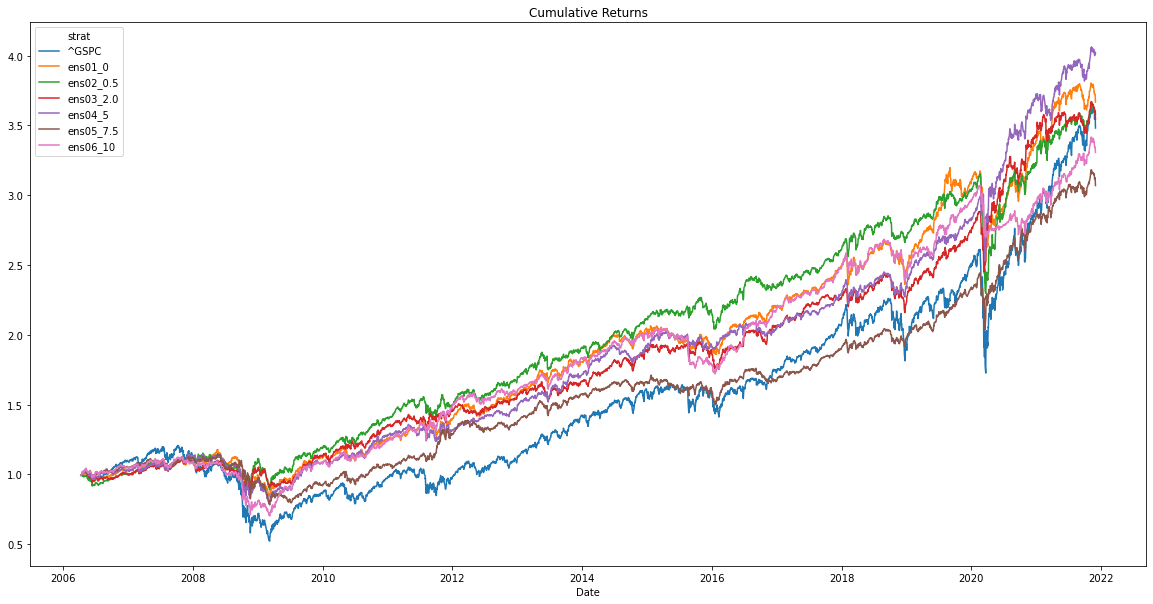

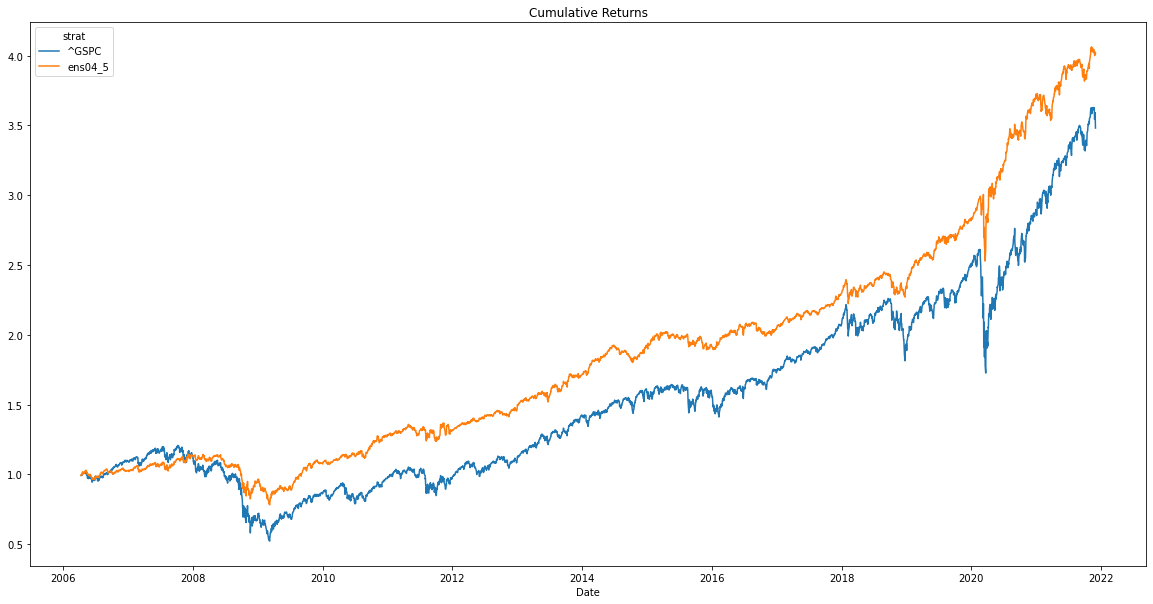

In [168]:
all_return_pivot.apply(lambda x: np.cumprod(1+x)).plot(figsize=(20,10), title="Cumulative Returns")
all_return_pivot.apply(lambda x: np.cumprod(1+x))[[bmk,"ens04_5"]].plot(figsize=(20,10), title="Cumulative Returns")

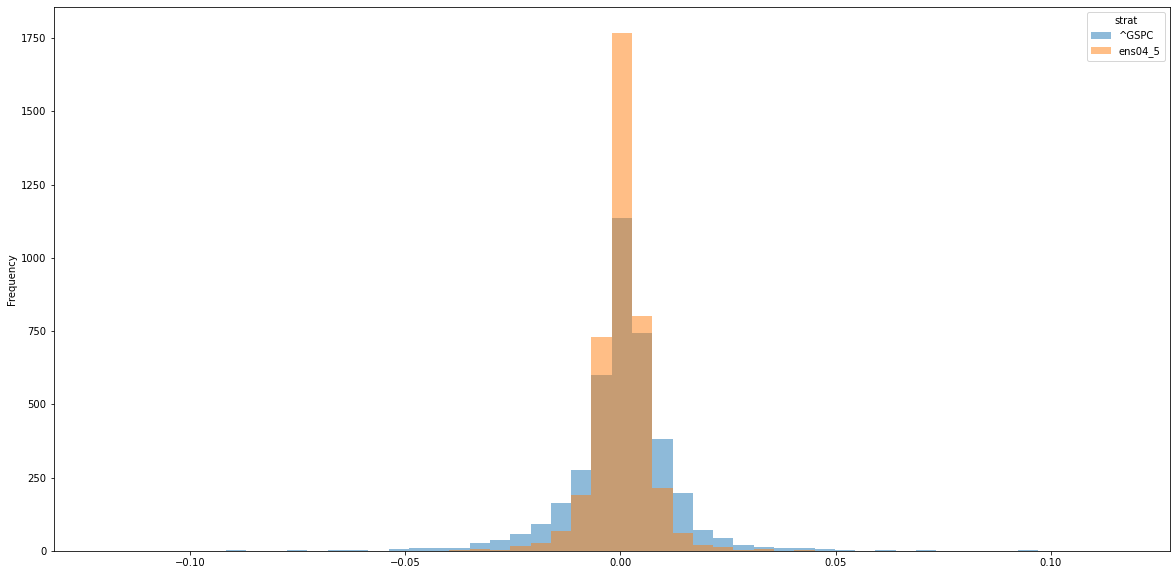

In [124]:
all_return_pivot[[bmk,"ens04_5"]].plot.hist(figsize=(20,10), bins=50, alpha=0.5)

In [78]:
def get_sharpe(all_return_pivot):
    return np.sqrt(252.0)*all_return_pivot.apply(lambda x: np.mean(x)/np.std(x),0)
   
get_sharpe(all_return_pivot)

strat
^GSPC        0.498842
ens01_0      0.818023
ens02_0.5    0.818964
ens03_2.0    0.817754
ens04_5      0.906177
ens05_7.5    0.700387
ens06_10     0.765902
dtype: float64

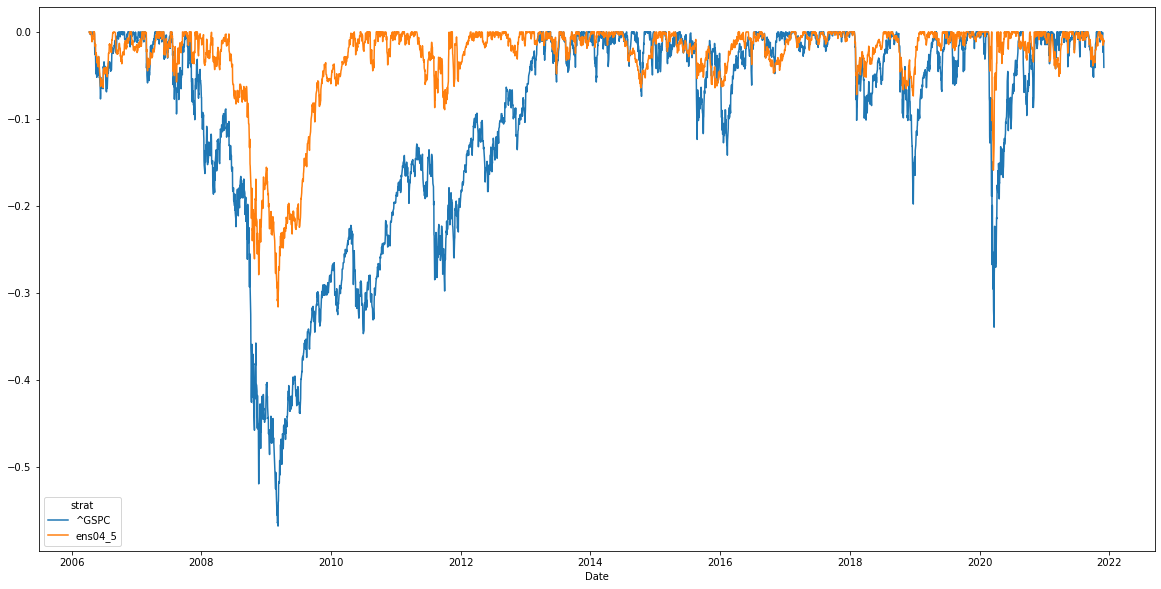

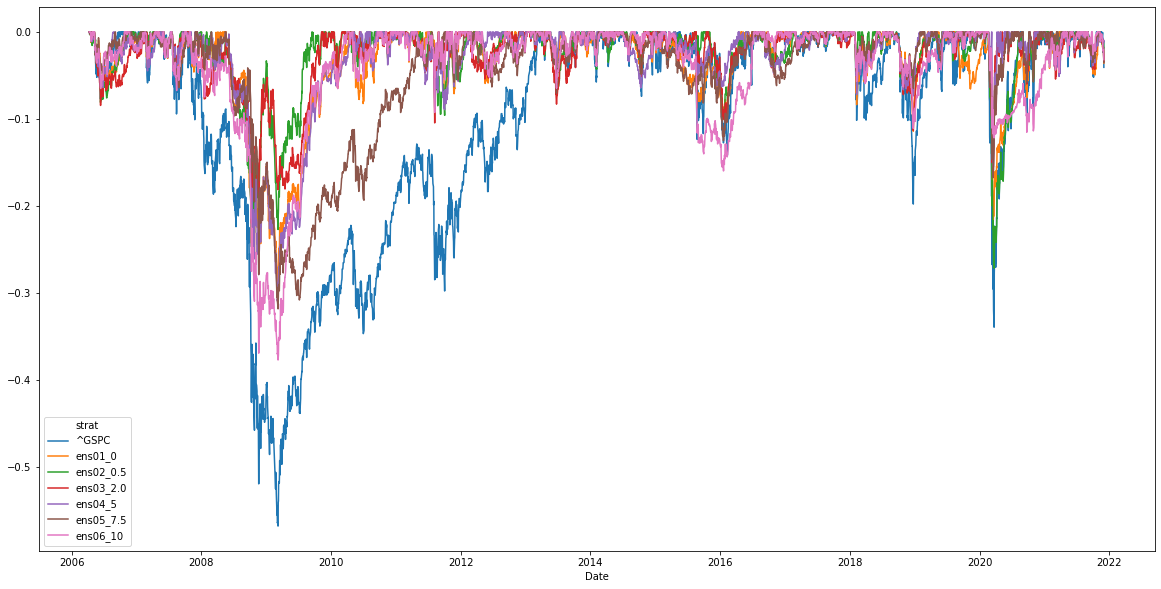

In [166]:
# Calculate max drawdown
def get_max_ddn(p_returns):
    wealth = (1.0 + p_returns).cumprod()
    #print(wealth)
    prev_peaks = wealth.cummax()
    #print(prev_peaks)
    drawdows = (wealth - prev_peaks)/prev_peaks
    return drawdows


max_ddns = all_return_pivot.apply(lambda x: get_max_ddn(x), 0)
max_ddns[[bmk,"ens04_5"]].plot(figsize=(20,10))
max_ddns.plot(figsize=(20,10))

In [112]:
def get_ir(all_return_pivot, bmk="^GSPC"):
    cols = [col for col in all_return_pivot.columns if col != bmk ]
    bmk_rets = all_return_pivot[[bmk]].values
    ir = np.sqrt(252.0)*all_return_pivot[cols].apply(lambda x: np.mean(x-bmk_rets)/np.std(x-bmk_rets),0)
    return ir
   
#get_ir(all_return_pivot)


cols = [col for col in all_return_pivot.columns if col != bmk ]
cols
all_return_pivot[cols]
bmk_rets = np.array(all_return_pivot[[bmk]].values).reshape(-1)
bmk_rets
all_return_pivot[cols].apply(lambda x: np.mean(x-bmk_rets)/np.std(x-bmk_rets),0)


strat
ens01_0     -0.005411
ens02_0.5   -0.006261
ens03_2.0   -0.006414
ens04_5     -0.002658
ens05_7.5   -0.011480
ens06_10    -0.008504
dtype: float64

In [70]:
ensemble_df.head()

,Date,account_value,daily_return,tc_cost
0,2006-04-10,1000000.000000,NaN,NaN
1,2006-04-11,994607.722781,-0.005392,0.000060
2,2006-04-12,995602.027166,0.001000,0.000115
3,2006-04-13,993089.621811,-0.002524,0.000088
4,2006-04-17,993514.057074,0.000427,0.000137


In [175]:
both_df = all_return_pivot[[bmk,"ens04_5"]].reset_index()
both_df

strat,Date,^GSPC,ens04_5
0,2006-04-11,-0.007751,-0.005392
1,2006-04-12,0.001205,0.000838
2,2006-04-13,0.000776,-0.002090
3,2006-04-17,-0.002940,0.000806
4,2006-04-18,0.017077,0.005757
...,...,...,...
3934,2021-11-24,0.002294,0.003314
3935,2021-11-26,-0.022725,-0.008471
3936,2021-11-29,0.013200,0.002309
3937,2021-11-30,-0.018961,0.003761


In [177]:
both_df[["Date",bmk]].columns

Index(['Date', '^GSPC'], dtype='object', name='strat')

In [183]:
def backtest_strat(df):
    print(df.columns)
    colname = df.columns[1]
    strategy_ret= df.copy()
    strategy_ret['Date'] = pd.to_datetime(strategy_ret['Date'])
    strategy_ret.set_index('Date', drop = False, inplace = True)
    strategy_ret.index = strategy_ret.index.tz_localize('UTC')
    del strategy_ret['Date']
    ts = pd.Series(strategy_ret.iloc[:,0].values, index=strategy_ret.index)
    return ts.rename(colname)
both_df[["Date",bmk]]

bmk_series = backtest_strat(both_df[["Date",bmk]])
bmk_series
ensemble_series = backtest_strat(both_df[["Date","ens04_5"]])
ensemble_series

Index(['Date', '^GSPC'], dtype='object', name='strat')
Index(['Date', 'ens04_5'], dtype='object', name='strat')


Date
2006-04-11 00:00:00+00:00   -0.005392
2006-04-12 00:00:00+00:00    0.000838
2006-04-13 00:00:00+00:00   -0.002090
2006-04-17 00:00:00+00:00    0.000806
2006-04-18 00:00:00+00:00    0.005757
                               ...   
2021-11-24 00:00:00+00:00    0.003314
2021-11-26 00:00:00+00:00   -0.008471
2021-11-29 00:00:00+00:00    0.002309
2021-11-30 00:00:00+00:00    0.003761
2021-12-01 00:00:00+00:00   -0.001691
Name: ens04_5, Length: 3939, dtype: float64

Start date,2006-04-11
End date,2021-12-01
Total months,187
,Backtest
Annual return,9.3%
Cumulative returns,301.7%
Annual volatility,10.4%
Sharpe ratio,0.91
Calmar ratio,0.29
Stability,0.95
Max drawdown,-31.6%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,31.60,2007-12-06,2009-03-09,2010-05-12,635
1,15.88,2020-03-10,2020-03-19,2020-04-09,23
2,8.94,2011-04-29,2011-10-03,2011-11-07,137
3,7.36,2018-08-29,2018-12-24,2019-01-30,111
4,7.20,2018-01-26,2018-02-08,2018-07-12,120


Stress Events,mean,min,max
Lehman,-0.14%,-3.03%,1.44%
US downgrade/European Debt Crisis,0.07%,-3.59%,3.42%
Fukushima,0.13%,-0.21%,0.78%
EZB IR Event,-0.08%,-1.04%,0.61%
Aug07,0.10%,-2.00%,1.58%
Mar08,-0.08%,-1.77%,1.47%
Sept08,-0.27%,-3.03%,1.40%
2009Q1,-0.37%,-3.61%,3.28%
2009Q2,0.15%,-2.96%,3.38%
Flash Crash,-0.03%,-0.71%,0.97%


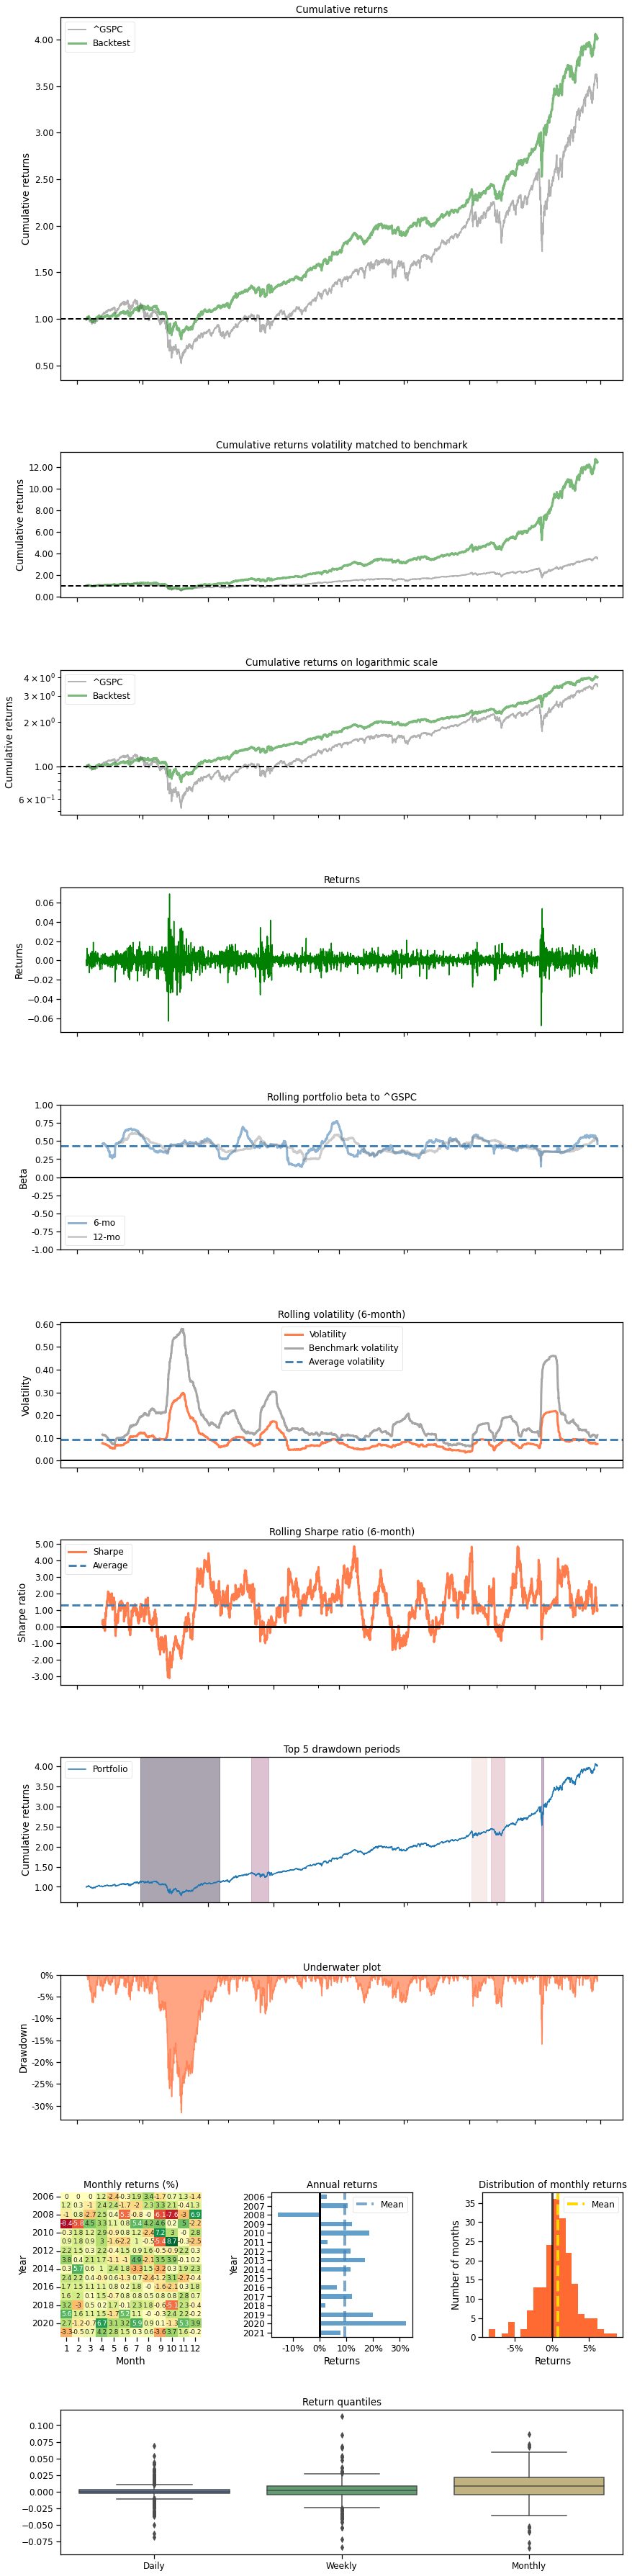

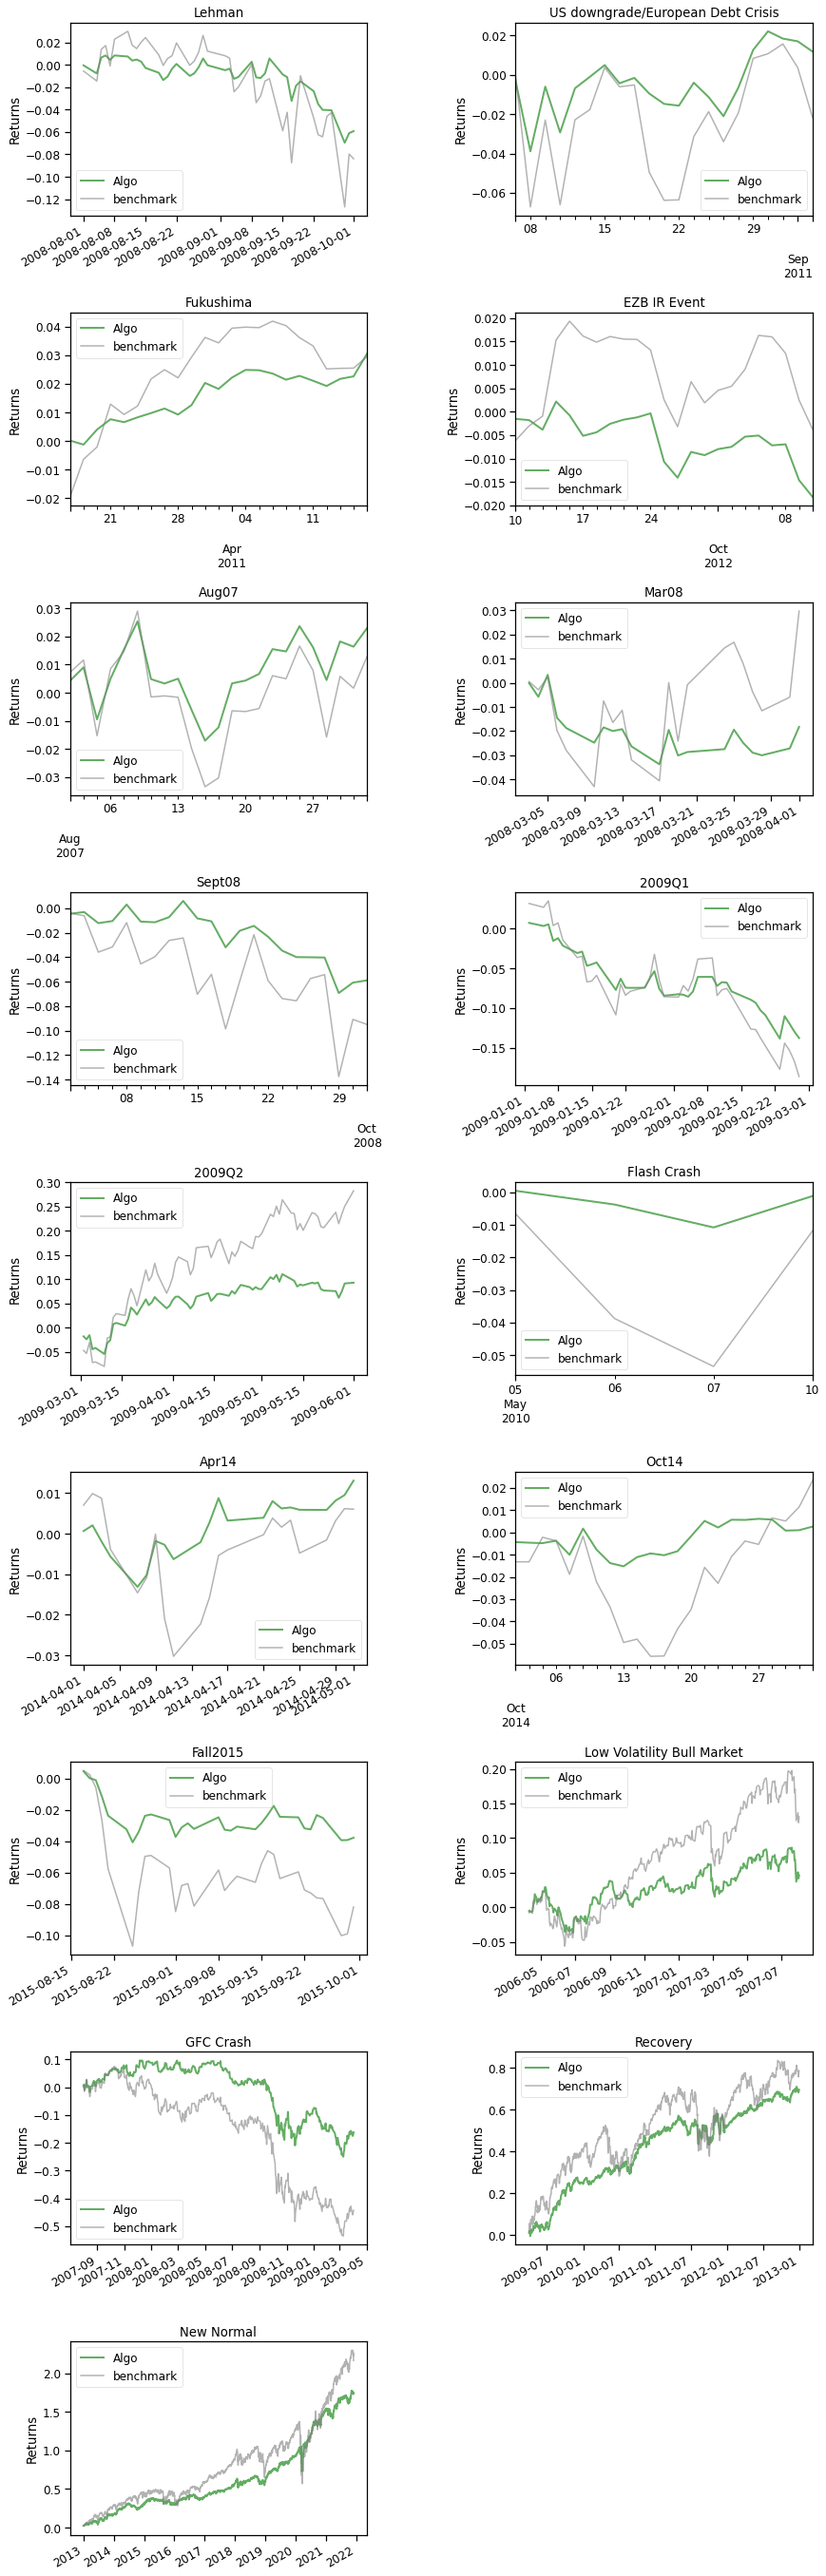

In [184]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = ensemble_series,
                                   benchmark_rets=bmk_series, set_context=False)